In [13]:
#Import the libraries we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from fredapi import Fred
from datetime import datetime
import time

In [ ]:
#Display library versions
print(f"Pandas version {pd.__version__}")
print(f"Numpy version {np.__version__}")
print(f"Seaborn version {sns.__version__}")
print(f"Statsmodels version {statsmodels.__version__}")

Pandas version 2.1.4
Numpy version 1.26.4
Seaborn version 0.13.1
Statsmodels version 0.14.2


In [ ]:
#Read in the data
xau_eur = pd.read_csv("Market Data XAUEUR.csv")
xau_eur = xau_eur.loc[96911:,:]
xau_eur.set_index("Time",inplace=True)
xau_eur.index = pd.to_datetime(xau_eur.index)
xau_eur.head()

,Open,High,Low,Close
Time,,,,
2012-09-24,1364.95,1366.20,1364.75,1364.78
2012-09-25,1364.86,1371.15,1360.30,1365.65
2012-09-26,1365.61,1372.02,1352.35,1361.80
2012-09-27,1361.75,1380.20,1360.60,1376.35
2012-09-28,1376.40,1381.40,1370.74,1377.80


In [6]:
#Fetch FRED data
fred = Fred(api_key='')
fred_euro_data = pd.DataFrame(fred.get_series('EVZCLS'),columns=["EVZCLS"])
fred_gold_data = pd.DataFrame(fred.get_series('GVZCLS'),columns=["GVZCLS"])
#Fill in any missing values with the column mean
fred_euro_data = fred_euro_data.fillna(fred_euro_data.mean())
fred_gold_data = fred_gold_data.fillna(fred_gold_data.mean())

In [ ]:
#Merge the data
merged_data = pd.merge(xau_eur,fred_euro_data,left_index=True,right_index=True)
merged_data = pd.merge(merged_data,fred_gold_data,left_index=True,right_index=True)
merged_data

,Open,High,Low,Close,EVZCLS,GVZCLS
2012-09-24,1364.95,1366.20,1364.75,1364.78,9.500000,16.940000
2012-09-25,1364.86,1371.15,1360.30,1365.65,9.480000,16.740000
2012-09-26,1365.61,1372.02,1352.35,1361.80,9.750000,16.310000
2012-09-27,1361.75,1380.20,1360.60,1376.35,9.470000,17.020000
2012-09-28,1376.40,1381.40,1370.74,1377.80,9.560000,16.760000
...,...,...,...,...,...,...
2024-08-30,2275.10,2279.72,2257.40,2265.72,7.490000,16.400000
2024-09-02,2264.61,2267.30,2253.03,2257.76,9.742967,18.565167
2024-09-03,2257.47,2269.89,2238.89,2257.26,8.250000,16.550000
2024-09-04,2256.90,2258.26,2236.49,2251.42,8.970000,16.190000


In [ ]:
#Let us label the data
look_ahead = 20

#Define the labels
merged_data["Target"] = merged_data["Close"].shift(-look_ahead)
merged_data["Binary Target"] = np.nan

merged_data.loc[merged_data["Target"] > merged_data["Close"],"Binary Target"] = 1
merged_data.loc[merged_data["Target"] <= merged_data["Close"],"Binary Target"] = 0

merged_data.dropna(inplace=True)
merged_data

,Open,High,Low,Close,EVZCLS,GVZCLS,Target,Binary Target
2012-09-24,1364.95,1366.20,1364.75,1364.78,9.50,16.94,1322.87,0.0
2012-09-25,1364.86,1371.15,1360.30,1365.65,9.48,16.74,1315.85,0.0
2012-09-26,1365.61,1372.02,1352.35,1361.80,9.75,16.31,1314.45,0.0
2012-09-27,1361.75,1380.20,1360.60,1376.35,9.47,17.02,1324.05,0.0
2012-09-28,1376.40,1381.40,1370.74,1377.80,9.56,16.76,1322.85,0.0
...,...,...,...,...,...,...,...,...
2024-08-02,2267.60,2285.44,2207.58,2237.44,8.85,18.70,2265.72,1.0
2024-08-05,2239.43,2248.28,2155.48,2200.47,16.88,21.95,2257.76,1.0
2024-08-06,2201.09,2214.46,2178.73,2186.06,12.67,19.10,2257.26,1.0
2024-08-07,2185.68,2204.62,2177.65,2181.38,12.67,18.12,2251.42,1.0


In [ ]:
#Let us define the predictors and target
ohlc_predictors = ["Open","High","Low","Close"]
fred_predictors = ["EVZCLS","GVZCLS"]
predictors = ohlc_predictors + fred_predictors
target = "Target"
binary_target = "Binary Target"

<Axes: >

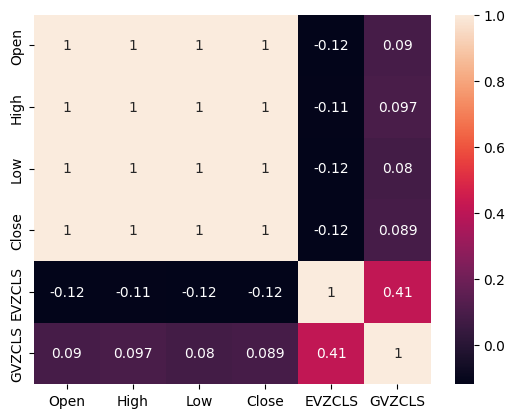

In [ ]:
#Exploratory Data Analysis
#Analyzing correlation levels
sns.heatmap(merged_data[predictors].corr(),annot=True)

<Axes: xlabel='GVZCLS', ylabel='Close'>

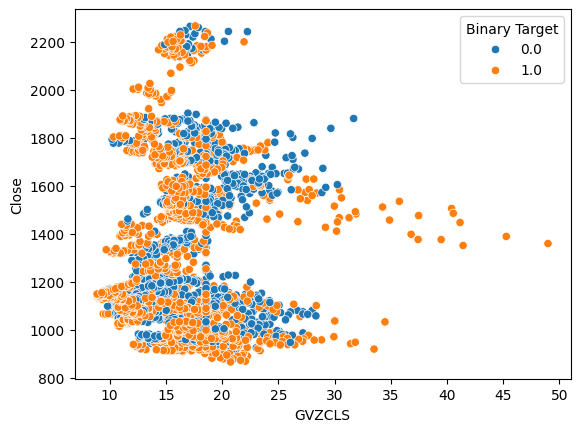

In [ ]:
#Let's create scatter plots
sns.scatterplot(data=merged_data,x="GVZCLS",y="Close",hue="Binary Target")

<Axes: xlabel='EVZCLS', ylabel='Close'>

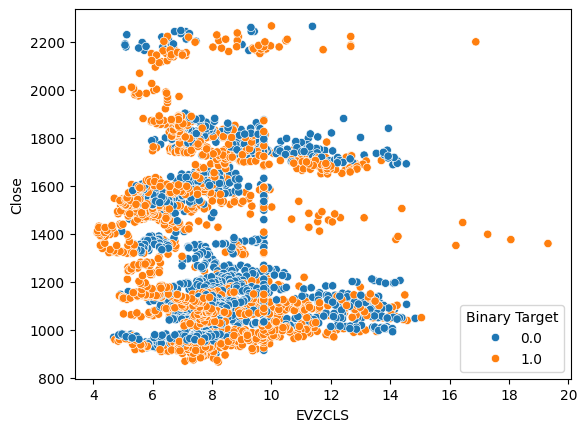

In [ ]:
#Let's create scatter plots
sns.scatterplot(data=merged_data,x="EVZCLS",y="Close",hue="Binary Target")

<Axes: xlabel='GVZCLS', ylabel='EVZCLS'>

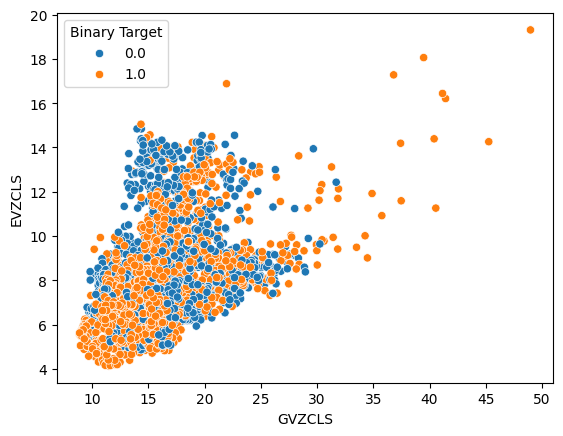

In [ ]:
#Let's create scatter plots
sns.scatterplot(data=merged_data,x="GVZCLS",y="EVZCLS",hue="Binary Target")

Text(0.5, 0, 'Close')

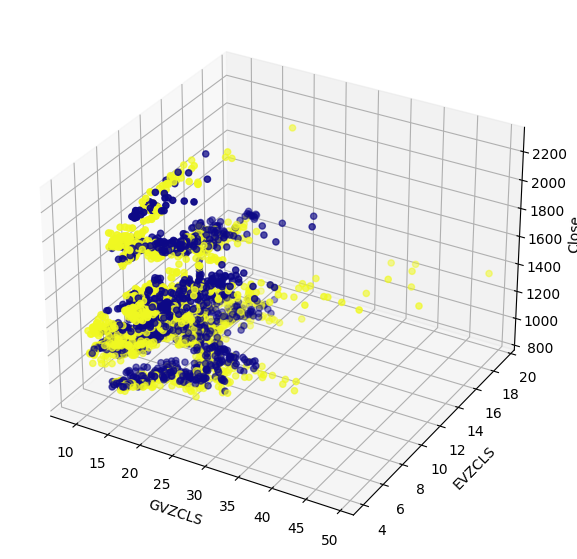

In [ ]:
#Define the 3D Plot
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection="3d")
ax.scatter(merged_data["GVZCLS"],merged_data["EVZCLS"],merged_data["Close"],c=merged_data["Binary Target"],cmap="plasma")
ax.set_xlabel("GVZCLS")
ax.set_ylabel("EVZCLS")
ax.set_zlabel("Close")

In [ ]:
#Let's create a TSNE Plot
from sklearn.manifold import TSNE

In [ ]:
#Create a TSNE object which will reduce the data to 2 dimensions
tsne = TSNE(n_components=2,perplexity=30)

In [ ]:
#Apply TSNE to the data
tsne_data = tsne.fit_transform(merged_data[predictors])

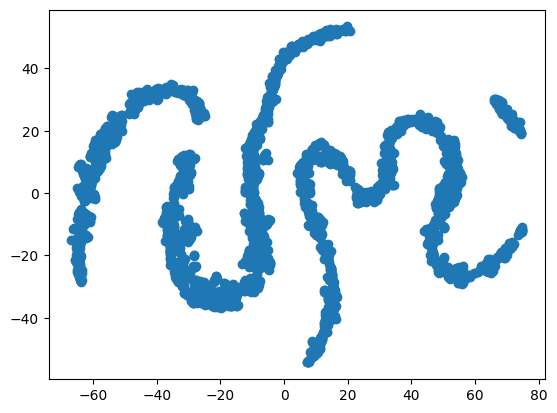

In [ ]:
#Create a scatter plot
plt.scatter(tsne_data[:,0],tsne_data[:,1])

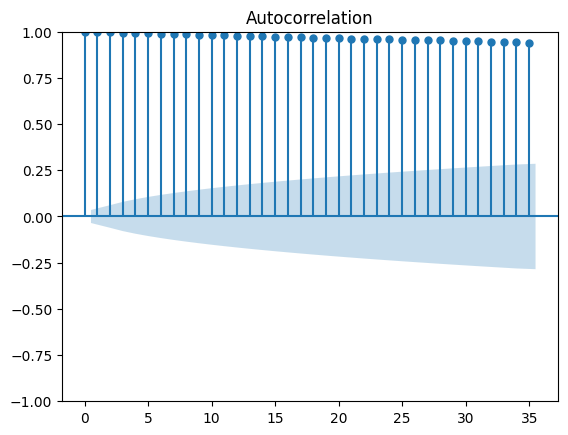

In [ ]:
#Let's look at an autocorrelation plot of the data
close_acf = plot_acf(merged_data["Close"])

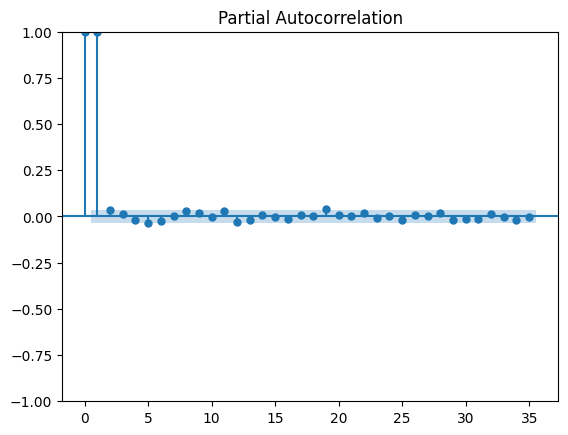

In [ ]:
#Let's look at an partial autocorrelation plot of the close data
close_pacf = plot_pacf(merged_data["Close"])

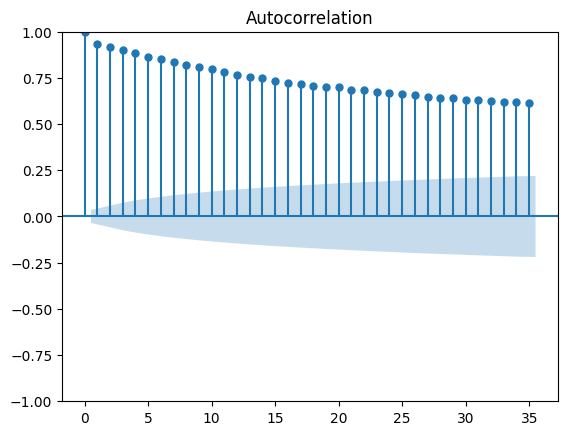

In [ ]:
#Let's look at an autocorrelation plot of the data
euro_acf = plot_acf(merged_data["EVZCLS"])

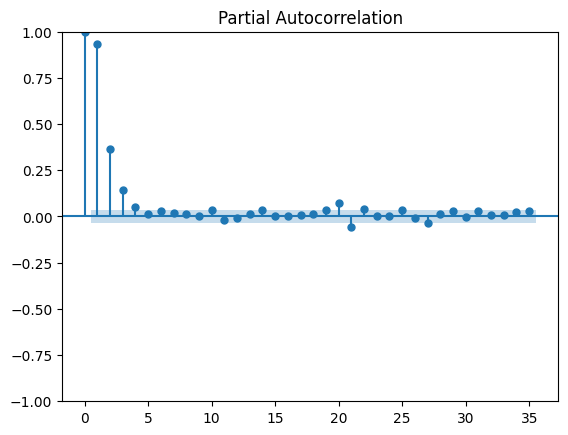

In [ ]:
#Let's look at an partial autocorrelation plot of the data
euro_pacf = plot_pacf(merged_data["EVZCLS"])

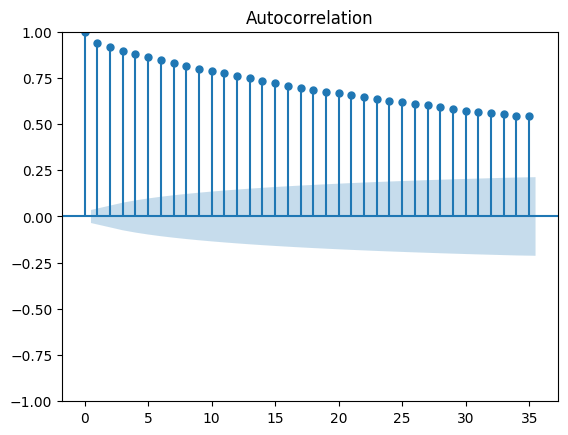

In [ ]:
#Let's look at an autocorrelation plot of the data
gold_acf = plot_acf(merged_data["GVZCLS"])

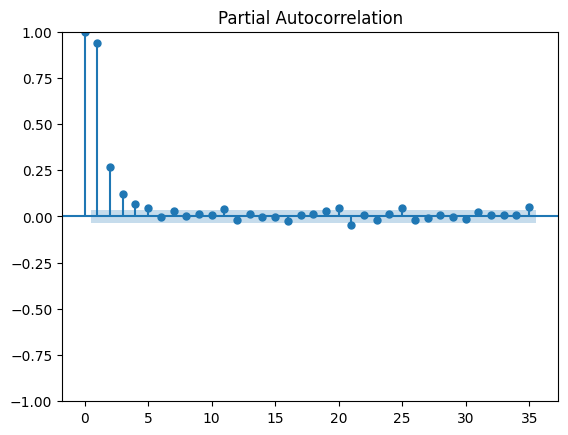

In [ ]:
#Let's look at an autocorrelation plot of the data
gold_acf = plot_pacf(merged_data["GVZCLS"])

In [ ]:
#Preparing to model the data
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import TimeSeriesSplit,train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor

In [ ]:
#Reset the index of our data
merged_data.reset_index(inplace=True)

X = merged_data.loc[:,predictors]
y = merged_data.loc[:,target]

#Scale our data
scaler = RobustScaler()
X = pd.DataFrame(scaler.fit_transform(merged_data[predictors]),columns=predictors)

In [ ]:
#Perform train test splits
ohlc_train_X,ohlc_test_X,train_y,test_y = train_test_split(X.loc[:,ohlc_predictors],y,shuffle=False,train_size=0.5)
fred_train_X,fred_test_X,_,_ = train_test_split(X.loc[:,fred_predictors],y,shuffle=False,train_size=0.5)
train_X,test_X,_,_ = train_test_split(X.loc[:,predictors],y,shuffle=False,train_size=0.5)

In [ ]:
#Let's now cross-validate each of the predictors
#Create the time-series split object
tscv = TimeSeriesSplit(n_splits=5,gap=look_ahead)

validation_error = pd.DataFrame(columns=["OHLC Predictors","FRED Predictors","All Predictors"],index=np.arange(0,5))

In [ ]:
#Performing cross validation
model = MLPRegressor(hidden_layer_sizes=(20,5))
for i,(train,test) in enumerate(tscv.split(train_X)):
  model.fit(train_X.loc[train[0]:train[-1],:],train_y.loc[train[0]:train[-1]])
  validation_error.iloc[i,2] = mean_squared_error(train_y.loc[test[0]:test[-1]],model.predict(train_X.loc[test[0]:test[-1],:]))

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

In [ ]:
#Our validation error
validation_error

,OHLC Predictors,FRED Predictors,All Predictors
0,875423.637167,881892.498319,857846.11554
1,794999.120981,831138.370726,946193.178747
2,1058884.292095,474744.732539,631259.842972
3,419566.842693,882615.372658,483408.373559
4,96693.318078,618647.934237,237935.04009


<Axes: >

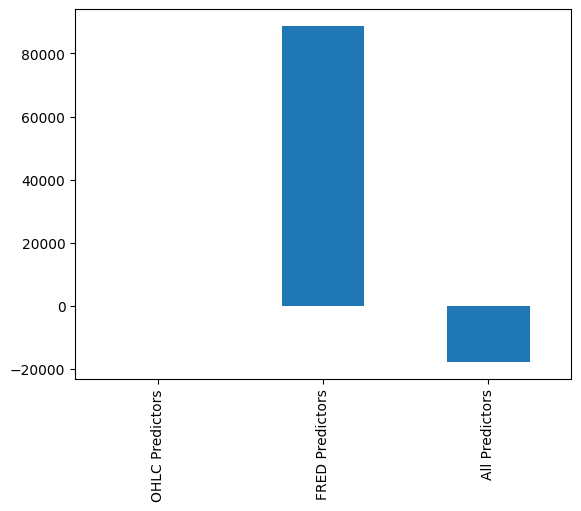

In [ ]:
#Our mean error levels
val_err = validation_error.mean()
val_err = val_err.iloc[:] - val_err.iloc[0]
val_err.plot(kind="bar")

<Axes: >

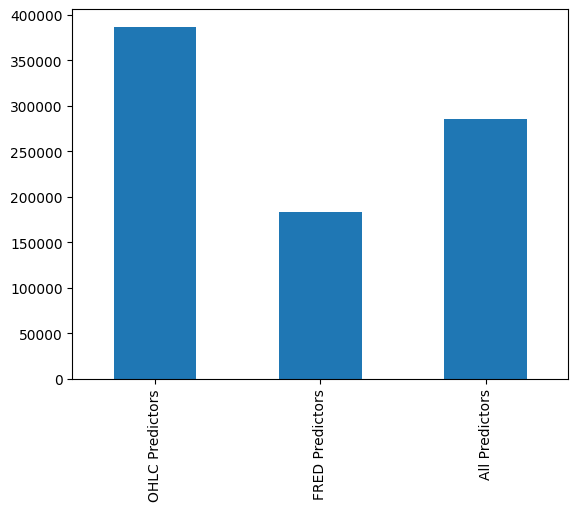

In [ ]:
#Our mean error levels
std = validation_error.std()
std.plot(kind="bar")

<Axes: >

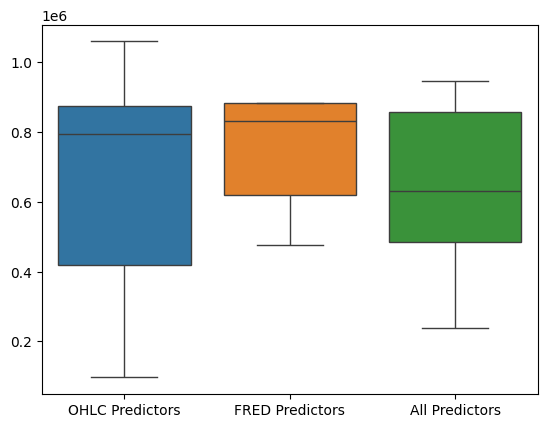

In [ ]:
#Let's perform boxplots of our validation error
sns.boxplot(validation_error)

In [ ]:
#Feature importance
from alibi.explainers import ALE , plot_ale

In [ ]:
#Explaining our deep neural network
model = MLPRegressor(hidden_layer_sizes=(20,5))
model.fit(train_X,train_y)
dnn_ale = ALE(model.predict,feature_names=predictors,target_names=["XAUEUR Close"])

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MLPRegress

array([[<Axes: xlabel='Open', ylabel='ALE'>,
        <Axes: xlabel='High', ylabel='ALE'>,
        <Axes: xlabel='Low', ylabel='ALE'>],
       [<Axes: xlabel='Close', ylabel='ALE'>,
        <Axes: xlabel='EVZCLS', ylabel='ALE'>,
        <Axes: xlabel='GVZCLS', ylabel='ALE'>]], dtype=object)

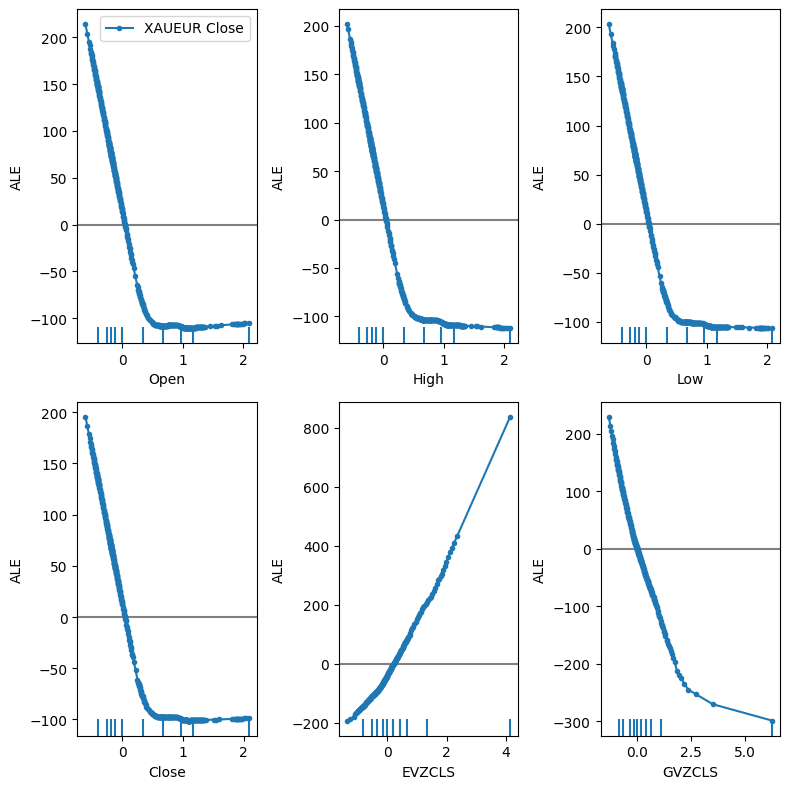

In [ ]:
#Obtaining the explanation
ale_X = X.to_numpy()
dnn_explanations = dnn_ale.explain(ale_X)
#Plotting feature importance
plot_ale(dnn_explanations,n_cols=3,fig_kw={'figwidth':8,'figheight':8},sharey=None)

In [ ]:
#SHAP Values
import shap

In [ ]:
#Calculating SHAP values
explainer = shap.Explainer(model.predict,train_X)
shap_values = explainer(test_X)

ExactExplainer explainer: 1535it [00:13, 47.11it/s]                           


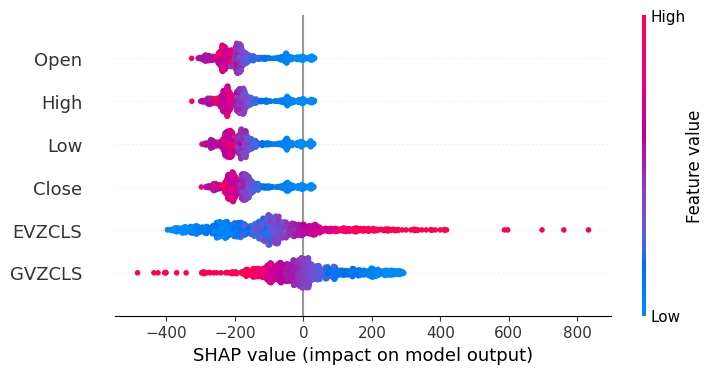

In [ ]:
#Plot the beeswarm plot
shap.plots.beeswarm(shap_values)

In [ ]:
#Parameter tuning
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
#Reinitialize the model
model = MLPRegressor(hidden_layer_sizes=(20,5))

In [ ]:
#Define the tuner
tuner = RandomizedSearchCV(
        model,
        {
        "activation" : ["relu","logistic","tanh","identity"],
        "solver":["adam","sgd","lbfgs"],
        "alpha":[0.1,0.01,0.001,0.0001,0.00001,0.00001,0.0000001],
        "tol":[0.1,0.01,0.001,0.0001,0.00001,0.000001,0.0000001],
        "learning_rate":['constant','adaptive','invscaling'],
        "shuffle": [True,False]
        },
        n_iter=500,
        cv=5,
        n_jobs=-1,
        scoring="neg_mean_squared_error"
)

In [ ]:
#Fit the tuner
tuner_results = tuner.fit(train_X,train_y)

In [ ]:
#The best parameters we found
tuner_results.best_params_

{'tol': 1e-07,
 'solver': 'lbfgs',
 'shuffle': True,
 'learning_rate': 'adaptive',
 'alpha': 0.1,
 'activation': 'identity'}

In [ ]:
#Create a dataframe
cv_results = pd.DataFrame(tuner_results.cv_results_)

Text(0.5, 0, 'Mean Validation Error')

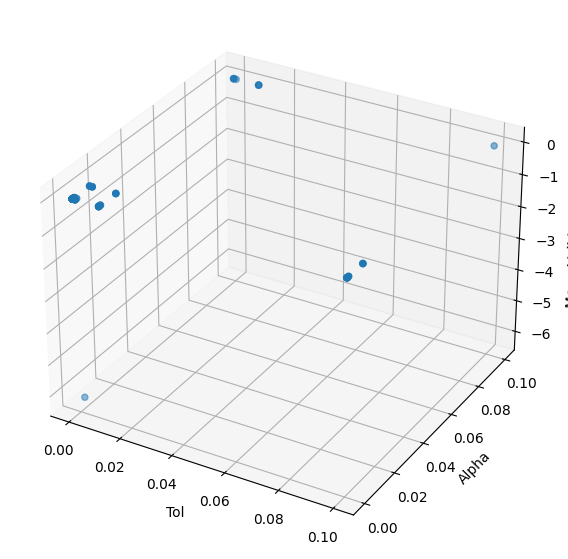

In [ ]:
#Define the 3D Plot
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection="3d")
ax.scatter(cv_results["param_tol"],cv_results["param_alpha"],cv_results["mean_test_score"])
ax.set_xlabel("Tol")
ax.set_ylabel("Alpha")
ax.set_zlabel("Mean Validation Error")

In [ ]:
#Deeper optimization
from scipy.optimize import minimize
from numpy.random import randn,rand

In [ ]:
#Create a dataframe to store our accuracy
current_error_rate = pd.DataFrame(index = np.arange(0,5),columns=["Current Error"])

In [ ]:
#Create the time series split object

In [ ]:
#Define the objective function
def objective(x):
    #The parameter x represents a new value for our neural network's settings
    #In order to find optimal settings, we will perform 10 fold cross validation using the new setting
    #And return the average RMSE from all 10 tests
    #We will first turn the model's Alpha parameter, which controls the amount of L2 regularization
    model = MLPRegressor(hidden_layer_sizes=(20,5),activation='identity',learning_rate='adaptive',solver='lbfgs',shuffle=True,alpha=x[0],tol=x[1])
    #Now we will cross validate the model
    for i,(train,test) in enumerate(tscv.split(train_X)):
        #Train the model
        model.fit(train_X.loc[train[0]:train[-1],:],train_y.loc[train[0]:train[-1]])
        #Measure the RMSE
        current_error_rate.iloc[i,0] = mean_squared_error(train_y.loc[test[0]:test[-1]],model.predict(train_X.loc[test[0]:test[-1],:]))
    #Return the Mean CV RMSE
    return(current_error_rate.iloc[:,0].mean())

In [ ]:
#Define the starting point
pt = [0.1,0.00000001]
bnds = ((0.0000000000000000001,10000000000),(0.0000000000000000001,10000000000))

In [ ]:
#Searchin deeper for parameters
result = minimize(objective,pt,method="L-BFGS-B",bounds=bnds)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

In [ ]:
#Testing for overfitting
default_model          = MLPRegressor(hidden_layer_sizes=(20,5))
customized_model       = MLPRegressor(hidden_layer_sizes=(20,5),activation='identity',learning_rate='adaptive',solver='lbfgs',shuffle=True,alpha=0.1,tol=0.0000001)
customized_lbfgs_model = MLPRegressor(hidden_layer_sizes=(20,5),activation='identity',learning_rate='adaptive',solver='lbfgs',shuffle=True,alpha=result.x[0],tol=result.x[1])

In [ ]:
#Preparing to cross validate the models
models = [
    default_model,
    customized_model,
    customized_lbfgs_model
]

#We will store our validation error here
validation_error = pd.DataFrame(columns=["Default Model","Customized Model","L-BFGS Model"],index=np.arange(0,5))

#We will now reset the indexes
test_y = test_y.reset_index()
test_X = test_X.reset_index()

In [ ]:
#Fit each of the models
for m in models:
  m.fit(train_X,train_y)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
#Cross validating each model
for j in np.arange(0,len(models)):
  model = models[j]
  for i,(train,test) in enumerate(tscv.split(test_X)):
    model.fit(test_X.loc[train[0]:train[-1],:],test_y.loc[train[0]:train[-1],"Target"])
    validation_error.iloc[i,j] = mean_squared_error(test_y.loc[test[0]:test[-1],"Target"],model.predict(test_X.loc[test[0]:test[-1],:]))

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modu

In [ ]:
#Our validation error
validation_error

,Default Model,Customized Model,L-BFGS Model
0,22360.060721,5917.062055,3734.212826
1,17385.289026,36726.684574,35886.972729
2,13782.649037,5128.022626,20886.845316
3,3082484.290698,6950.786438,5789.948045
4,4076009.132941,27729.589769,22931.572161


In [ ]:
#Our mean error levels
validation_error.mean()

,0
Default Model,1442404.284485
Customized Model,16490.429092
L-BFGS Model,17845.910215


<Axes: >

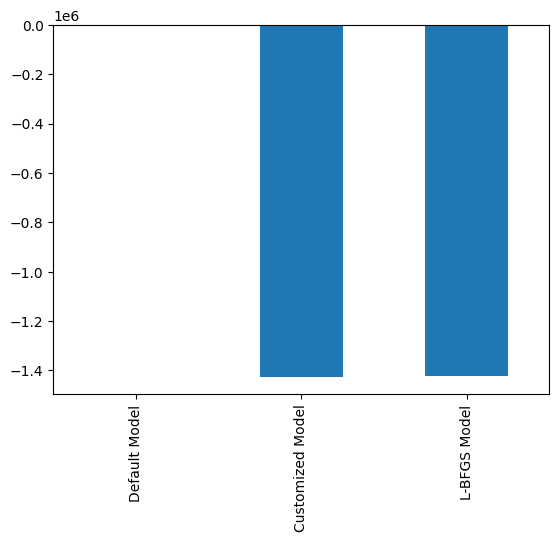

In [ ]:
#Plotting the difference in our performance levels
mean = validation_error.mean()
mean = mean.iloc[:] - mean.iloc[0]
mean.plot(kind="bar")

<Axes: >

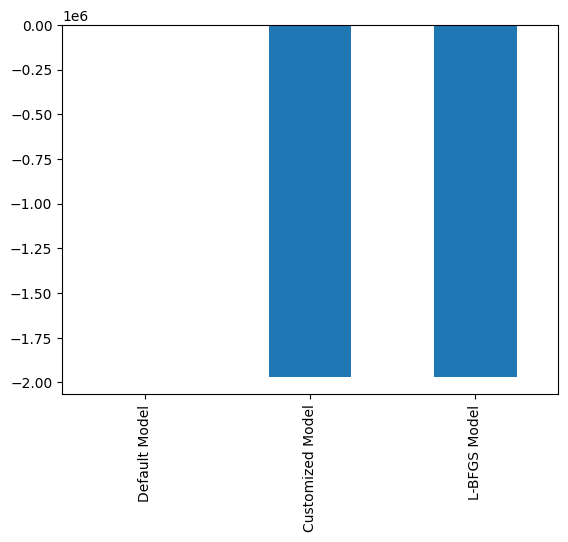

In [ ]:
#Visualizing the results
std = validation_error.std()
std = std.iloc[:] - std.iloc[0]
std.plot(kind="bar")

<Axes: >

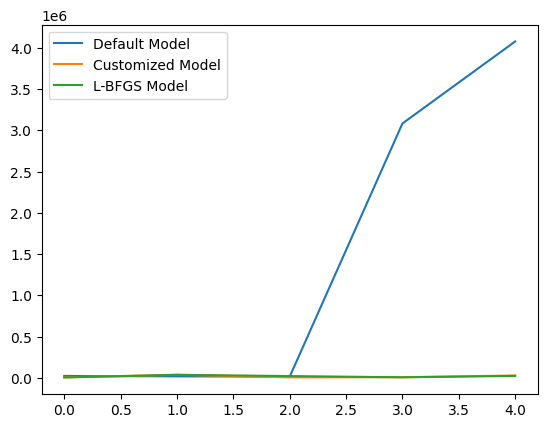

In [ ]:
#Visualizing the results
validation_error.plot()

<Axes: >

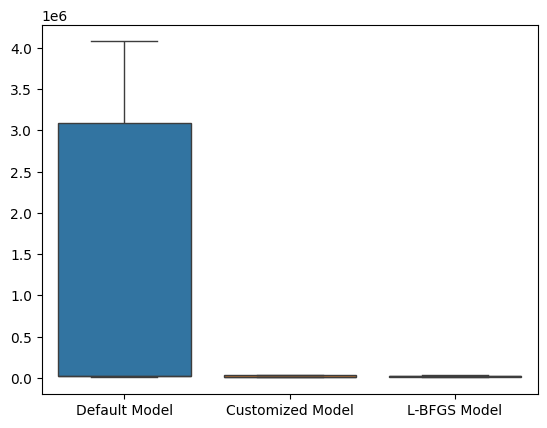

In [ ]:
#Visualizing our results
sns.boxplot(validation_error)

In [ ]:
#Let us now prepare to export our model to onnx format
scale_factors = pd.DataFrame(columns=predictors,index=["mean","standard deviation"])

for i in np.arange(0,len(predictors)):
  scale_factors.iloc[0,i] = merged_data.loc[:,predictors[i]].mean()
  scale_factors.iloc[1,i] =  merged_data.loc[:,predictors[i]].std()
  merged_data.loc[:,predictors[i]] = (merged_data.loc[:,predictors[i]] - merged_data.loc[:,predictors[i]].mean())/merged_data.loc[:,predictors[i]].std()

scale_factors

,Open,High,Low,Close,EVZCLS,GVZCLS
mean,1331.496453,1340.228096,1323.377633,1331.706769,8.258128,16.355824
standard deviation,329.722208,332.114955,327.732779,330.114605,2.199782,4.241113


In [ ]:
#Save the scale factors to CSV
scale_factors.to_csv("scale_factors.csv")

In [ ]:
#Our scaled data
merged_data

,index,Open,High,Low,Close,EVZCLS,GVZCLS,Target,Binary Target
0,2012-09-24,0.101460,0.078202,0.126238,0.100187,0.564543,0.137741,1322.87,0.0
1,2012-09-25,0.101187,0.093106,0.112660,0.102823,0.555452,0.090584,1315.85,0.0
2,2012-09-26,0.103461,0.095726,0.088402,0.091160,0.678191,-0.010805,1314.45,0.0
3,2012-09-27,0.091755,0.120356,0.113575,0.135236,0.550906,0.156604,1324.05,0.0
4,2012-09-28,0.136186,0.123969,0.144515,0.139628,0.591819,0.095299,1322.85,0.0
...,...,...,...,...,...,...,...,...,...
3062,2024-08-02,2.839067,2.846038,2.697937,2.743693,0.269060,0.552727,2265.72,1.0
3063,2024-08-05,2.753632,2.734149,2.538966,2.631702,3.919421,1.319035,2257.76,1.0
3064,2024-08-06,2.637352,2.632317,2.609908,2.588050,2.005595,0.647041,2257.26,1.0
3065,2024-08-07,2.590616,2.602689,2.606613,2.573873,2.005595,0.415970,2251.42,1.0


In [ ]:
#Exporting to ONNX format
import onnx
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

In [ ]:
#Fit the model on all the data we have
customized_model.fit(merged_data.loc[:,predictors],merged_data.loc[:,target])

MLPRegressor(activation='identity', alpha=0.1, hidden_layer_sizes=(20, 5),
             learning_rate='adaptive', solver='lbfgs', tol=1e-07)

In [ ]:
# Define the input type
initial_types = [("float_input",FloatTensorType([1,6]))]

In [ ]:
# Create the ONNX representation
onnx_model = convert_sklearn(customized_model,initial_types=initial_types,target_opset=12)

In [ ]:
# Save the ONNX model
onnx_name = "XAUEUR FRED D1.onnx"
onnx.save_model(onnx_model,onnx_name)

In [20]:
#A function to write out our alternative data to CSV
def write_out_alternative_data():
        euro = fred.get_series("EVZCLS")
        euro = euro.iloc[-1]
        gold = fred.get_series("GVZCLS")
        gold = gold.iloc[-1]
        data = pd.DataFrame(np.array([euro,gold]),columns=["Data"],index=["Fred Euro","Fred Gold"])
        #data.to_csv("C:\\Users\\Westwood\\AppData\\Roaming\\MetaQuotes\\Terminal\\D0E8209F77C8CF37AD8BF550E51FF075\\MQL5\\Files\\fred_visa.csv")
        data.to_csv("fred_xau_eur.csv")

In [21]:
write_out_alternative_data()

In [ ]:
while True:
        #Update the fred data for our MT5 EA
        write_out_alternative_data()
        #If we have finished all checks then we can wait for one day before checking for new data
        time.sleep(24 * 60 * 60)